In [1]:
begin
    using Pkg
    Pkgs = ["CSV", "DataFrames", "Ipopt", "JuMP", "Plots", "DelimitedFiles", "LaTeXStrings", "SparseArrays"]
    for p in Pkgs
        if Base.find_package(p) == nothing
            Pkg.add(p)
        end
    end
end
    using CSV, DataFrames, Ipopt, JuMP, Plots, DelimitedFiles, LaTeXStrings, SparseArrays

In [2]:
S_base = readdlm("data/BaseMVA.txt")[1,1]

10.0

In [3]:
BusData = CSV.read("data/bus.csv", DataFrame)
GenData = CSV.read("data/gen.csv", DataFrame)
GenCostData = CSV.read("data/gencost.csv", DataFrame)
BranchData = CSV.read("data/branch.csv", DataFrame)
#DemandData = CSV.read("data/demand.csv", DataFrame)

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,2.0,0.0,0.1,0.0,30.0,250.0,250.0,0.0


In [4]:
Gens = 1:size(GenData)[1]
Buses = 1:size(BusData)[1]
T = 1:720#17280

1:720

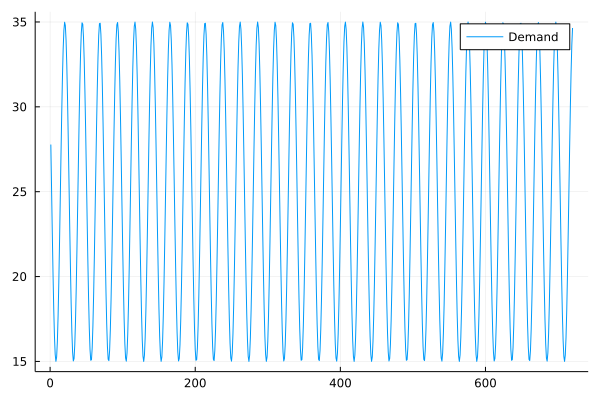

In [5]:
# Generate demand data
Demand = []
for t in T
    append!(Demand, 10*sin(0.26 * (t + 10)) + 25)
end
#@show Demand[1]
#plot(Demand)
DemandData = DataFrame(b1 = Float64[], b2 = Float64[])

for i in T
    push!(DemandData, (0.0, Demand[i]))
end 

DemandData = DataFrame([[names(DemandData)]; collect.(eachrow(DemandData))], [:column; Symbol.(axes(DemandData, 1))])
DemandData = select!(DemandData, Not(:column))
plot(Demand, label="Demand")#, xlim = [1, 24], ylim = [0, 40])

In [6]:
GenCostData

,2,startup,shutdown,n,c2,c1,c0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,1500.0,0.0,3.0,0.0,40.0,0.0
2,2.0,2000.0,0.0,3.0,0.0,160.0,0.0


In [7]:
BusData

,bus_i,type,Pd,Qd,Gs,Bs,area,Vm,Va
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [8]:
NBuses = size(BusData)[1]
NLines = size(BranchData)[1]
Y = zeros(Complex, NBuses, NBuses)
b = zeros(NBuses, NBuses)
X = zeros(NBuses, NBuses)
BranchData[!,"fbus"] = convert.(Int64, BranchData[!,"fbus"])
BranchData[!,"tbus"] = convert.(Int64, BranchData[!,"tbus"])

for row in eachrow(BranchData)
    # Non-diagonal elements of Y
    Y[row["fbus"], row["tbus"]] = Y[row["fbus"], row["tbus"]] - (1 / (row["r"] + im*row["x"])) 
    Y[row["tbus"], row["fbus"]] = Y[row["tbus"], row["fbus"]] - (1 / (row["r"] + im*row["x"]))
    
    # Diagonal elements of Y
    Y[row["fbus"], row["fbus"]] = Y[row["fbus"], row["fbus"]] + (1 / (row["r"] + im*row["x"])) 
    Y[row["tbus"], row["tbus"]] = Y[row["tbus"], row["tbus"]] + (1 / (row["r"] + im*row["x"]))
    
    # Shunt susceptance
    b[row["fbus"], row["tbus"]] = row["b"]
    b[row["tbus"], row["fbus"]] = row["b"]
    
    # Reactence matrix
    X[row["fbus"], row["tbus"]] = row["x"]
    X[row["tbus"], row["fbus"]] = row["x"]
end

G = real(Y)
B = imag(Y)

Lines = [(row["fbus"], row["tbus"]) for row in eachrow(BranchData)]

1-element Vector{Tuple{Int64, Int64}}:
 (1, 2)

In [9]:
Y

2×2 Matrix{Complex}:
 0.0-10.0im  0.0+10.0im
 0.0+10.0im  0.0-10.0im

In [10]:
# Lines' apparent power limits

S = zeros(NBuses,NBuses)
for i in 1:NLines
    S[BranchData[i,:fbus],BranchData[i,:tbus]] = BranchData[i,:rateA] # Choose rateA column because it is for the long-term case
    S[BranchData[i,:tbus],BranchData[i,:fbus]] = BranchData[i,:rateA]
end

In [11]:
#DC OPF
function DCPF(G, B, b, S, BusData, DemandData, GenData, Gens, Buses, T)
    """
    This function creates a JuMP model for Optimal Power Flow (OPF) problem with provided parameters of power grid
    
    Arguments:
        G (Matrix{Real})        : conductance matrix of grid -- real part of admittance matrix
        B (Matrix{Real})        : susceptance matrix of grid -- imaginary part of admittance matrix
        b (Matrix{Float64})     : shunt matrix for lines
        S (Matrix{Float64})     : line flow limits matrix
        BusData (DataFrame)     : contains information on buses: power demands and voltage magnitude limits
        GenData (DataFrame)     : contains information on generators: generation limits and 
                                  quadratic cost function's coefficients
        Gens (UnitRange{Int64}) : indices of generators
        Buses (UnitRange{Int64}): indices of buses
    Returns:
        
    """
    
    m = Model(Ipopt.Optimizer)
    #set_optimizer_attribute(m, "max_cpu_time", 240.0)
    set_optimizer_attribute(m, "max_iter", 500)
    set_optimizer_attribute(m, "acceptable_tol", 1.0)
    
    #set_optimizer_attribute(m, "max_wall_time", 30.0) - should limit the real time but doesn't work
    
    # Battery parameters
    Emax0 = 100.0      # Initial capacitance
    Emin = 10.0        # Minimum capacity
    η_ch = 0.8         # Charging efficiency
    η_disch = 0.85     # Discharging efficiency
    
    # Idling degradation
    # Numbers from the article are multiplied by 10 to increase the speed of degradation
    A_idl = 0.00000602 * 10
    B_idl = 0.0000135  * 10
    C_idl = 0.0000185  * 10
    
    # Cycling degradation
    A_cyc = -0.0000472 * 10
    B_cyc =  0.0000962 * 10
    
    # Variables
    
    ## Voltages
    @variable(m, BusData[i, :Vmin] ≤ v[i in Buses, t in T] ≤ BusData[i, :Vmax], start = 1.0)
    @variable(m, δ[i in Buses, t in T], start = 0.0)
    
    ## Power generations
    @variable(m, GenData[i, :Pmin] ≤ p[i in Gens, t in T] ≤ GenData[i, :Pmax])
    @variable(m, GenData[i, :Qmin] ≤ q[i in Gens, t in T] ≤ GenData[i, :Qmax])
        
    ## Battery
    @variable(m, Emax[t in T], start = Emax0)
    @variable(m, E[t in T], start = Emin)
    @variable(m, 0.0 ≤ Pch[i in Buses, t in T] ≤ 25.0)
    @variable(m, 0.0 ≤ Pdisch[i in Buses, t in T] ≤ 40.0)
    @variable(m, γ_idl[t in T])
    @variable(m, γ_cyc[t in T])
    @variable(m, SoC[t in T])
    @variable(m, DoD[t in T])
    @variable(m, y[t in T])     # Ratio of the cycle, y = (Pch + Pdis)/Emax0
    
    ### No simultaneous charge and discharge
    @NLconstraint(m, Psim[i in Buses, t in T], abs(Pch[i, t] * Pdisch[i, t]) ≤ 0.00001)# == 0.0)
    
    ### SoC and DoD definitions
    @constraint(m, SoC_definition[t in T], SoC[t] == E[t] / Emax0)
    @constraint(m, DoD_definition[t in T], DoD[t] == 1 - SoC[t])
    @constraint(m, y_definition[t in T], y[t] == (Pch[2, t] + Pdisch[2, t]) / Emax0)
    
    ### Initialization of parameters in initial condition
    @constraint(m, Et_init, E[1] == Emin)
    @constraint(m, Emax_init, Emax[1] == Emax0)
    @constraint(m, Pch2_init, Pch[2, 1] == 0.0)
    @constraint(m, Pdisch2_init, Pdisch[2, 1] == 0.0)
    
    ### No battery at bus #1
    @constraint(m, Pch1[t in T], Pch[1, t] == 0.0)      
    @constraint(m, Pdisch1[t in T], Pdisch[1, t] == 0.0) 
    
    ### Capacitance limit
    @constraint(m, MaxCapacity[t in T], E[t] ≤ Emax[t])
    @constraint(m, MinCapacity[t in T], Emin ≤ E[t])
    
    ### Degradation model
    @constraint(m, IdlingDegradation[t in T],  γ_idl[t] == A_idl * (SoC[t])^2 + B_idl * (SoC[t]) + C_idl)
    @constraint(m, CyclingDegradation[t in T], γ_cyc[t] == A_cyc * (DoD[t])^2 + B_cyc * (DoD[t]))
    @NLconstraint(m, Degradation[t in 2:size(T)[1]],                      
                Emax[t] == Emax[t - 1] * (1 - γ_idl[t - 1] - y[t] * γ_cyc[t - 1]) ) 
                # ((Pch[2, t - 1] + Pdisch[2, t - 1])/Emax0) *

    
    @constraint(m, Et[t in 2:size(T)[1]], E[t] == E[t - 1] - (Pdisch[2, t - 1] / η_disch) +  (η_ch * Pch[2, t - 1]))
    
    @constraint(m, Pdisch21[t in T], E[t] - Pdisch[2, t] / η_disch ≥ Emin )
    @constraint(m, Pch21[t in T], E[t] + η_ch * Pch[2, t] ≤ Emax[t] )
    
    ## Power flows
    @variable(m, pij[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)])
    @variable(m, qij[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)])
    
    #Constraints
    
    ##Slack bus
    @constraint(m, δ_slack[t in T], δ[1, t] == 0.0)
    
    ## Power flow through lines
    @NLconstraint(m, p_line[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                     pij[i, j, t] == (δ[i, t] - δ[j, t]) / X[i, j] #S_base * 
    )
    @NLconstraint(m, q_line[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                     qij[i, j, t] == (v[i, t] - v[j, t])/ X[i, j] #S_base * 
    )
    ## Nodal balance
    @NLconstraint(m, P_bus[i in Buses, t in T],
                    sum(p[g, t] for g in Gens if (g == i)) - DemandData[i, t] - Pch[i, t] + Pdisch[i, t] - 
                    sum(pij[i, j, t] for j in Buses if ((i != j) && (abs(Y[i, j]) > 0.))) == 0
                    
    )

    
    @NLconstraint(m, Q_bus[i in Buses, t in T],
                    sum(q[g, t] for g in Gens if g == i) - BusData[i, :Qd] - 
                    sum(qij[i, j, t] for j in Buses if ((i != j) && (abs(Y[i, j]) > 0.))) == 0
    )
    
    ## Line limits
    @NLconstraint(m, S_max[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                    pij[i, j, t]^2 + qij[i, j, t]^2 ≤ 50^2 #S[i, j]^2
        
    )
    
    ## Phase angle difference
    @constraint(m, δ_diff[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                    -pi ≤ δ[i, t] - δ[j, t] ≤ pi
    )
    
    # Objective
    @objective(m, Min, sum(p[g, t]^2 * GenCostData[g, :c2] + 
                           p[g, t]^1 * GenCostData[g, :c1] + 
                                       GenCostData[g, :c0]
                           for g in Gens for t in T))
    
    # Solve
    JuMP.optimize!(m)
    return m
end

DCPF (generic function with 1 method)

In [12]:
@time mDCPF = DCPF(G, B, b, S, BusData, DemandData, GenData, Gens, Buses, T)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    35275
Number of nonzeros in inequality constraint Jacobian.:    17280
Number of nonzeros in Lagrangian Hessian.............:    15830

Total number of variables............................:    16560
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     7200
                     variables with only upper bounds:        0
Total number of equal

A JuMP Model
Minimization problem with:
Variables: 16560
Objective function type: QuadExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 5043 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 720 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 2160 constraints
`AffExpr`-in-`MathOptInterface.Interval{Float64}`: 1440 constraints
`QuadExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1440 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 7200 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 7200 constraints
Nonlinear: 9359 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: CyclingDegradation, Degradation, DoD, DoD_definition, E, Emax, Emax_init, Et, Et_init, IdlingDegradation, MaxCapacity, MinCapacity, P_bus, Pch, Pch1, Pch21, Pch2_init, Pdisch, Pdisch1, Pdisch21, Pdisch2_init, Psim, Q_bus, S_max, SoC, SoC_definition, p, p_line, pij, q, q_line, q

In [13]:
#@show mDCPF[:S_max]
x = value.(mDCPF[Symbol("Emax")])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:720
And data, a 720-element Vector{Float64}:
 100.0
  99.97802647241349
  99.95561735740955
  99.932496954063
  99.90876262962908
  99.88447193886222
  99.85965487492159
  99.83433717128767
  99.8085488667142
  99.7823248668489
  99.75570543873691
  99.72873829178586
  99.70148118919069
   ⋮
  82.67003622125735
  82.65274944234139
  82.63545051412036
  82.6181400331716
  82.60081859226972
  82.58348682337606
  82.56614550397444
  82.54879594006117
  82.53144277854659
  82.51387114978645
  82.49567414608588
  82.47718471316037

In [14]:
p = value.(mDCPF[Symbol("p")])
pij = value.(mDCPF[Symbol("pij")])
qij = value.(mDCPF[Symbol("qij")])
E = value.(mDCPF[Symbol("E")])
Emax = value.(mDCPF[Symbol("Emax")])
pdis = value.(mDCPF[Symbol("Pdisch")])
pch = value.(mDCPF[Symbol("Pch")])

S_max = []
for i in eachindex(pij)
   S_i = pij[i]^2 + qij[i]^2
   append!(S_max, S_i)
end

results = DataFrame(P2 = Float64[], P1 = Float64[], E = Float64[], 
                    Pch = Float64[], Pdis = Float64[], Demand = Float64[], S_max = Float64[])

for i in T
    push!(results, round.(tuple(p[2, i], p[1, i], E[i], pch[2, i], pdis[2, i], DemandData[!,i][2], S_max[i]), digits=2))
end

In [15]:
S_max

1440-element Vector{Any}:
 303.38206890998697
 986.9604598213782
 293.01751597573076
 986.9604598213782
 363.12094055137004
 558.0699067492272
 696.8572093849632
 297.0511177929161
 298.51558322889383
 818.8786707014174
 986.9604598213782
 986.9604598213782
 688.2649403762244
   ⋮
 567.757859557217
 287.05994523222495
 655.6378724989228
 948.9572161061683
 488.6112140979146
 888.3744436904816
 443.65933159104026
 577.3418757391432
 986.9604598213782
 986.9604598213782
 257.4023925213539
 635.0011074089992

In [16]:
results

,P2,P1,E,Pch,Pdis,Demand,S_max
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,27.78,10.0,0.0,0.0,27.78,303.38
2,0.0,29.48,10.0,4.27,0.0,25.22,986.96
3,0.0,27.82,13.41,5.18,0.0,22.64,293.02
4,0.0,25.88,17.56,5.66,0.0,20.22,986.96
5,0.0,23.83,22.08,5.71,0.0,18.12,363.12
6,0.0,21.97,26.65,5.48,0.0,16.49,558.07
7,0.0,20.56,31.03,5.14,0.0,15.42,696.86
8,0.0,19.75,35.14,4.75,0.0,15.01,297.05
9,0.0,19.59,38.94,4.33,0.0,15.26,298.52


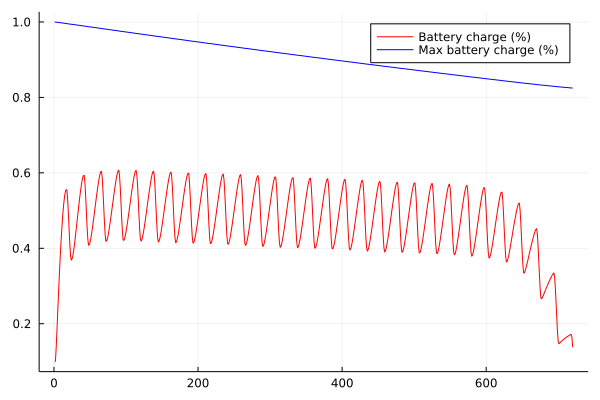

In [17]:
plot(E / 100, label="Battery charge (%)", color=:red)
plot!(Emax / 100, label="Max battery charge (%)", color=:blue)

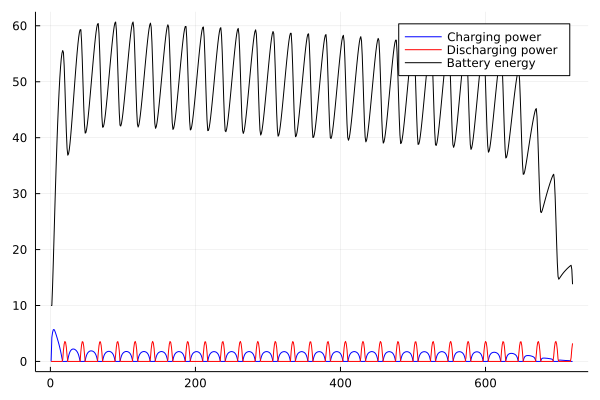

In [18]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(results[!, :E], label="Battery energy", color=:black)

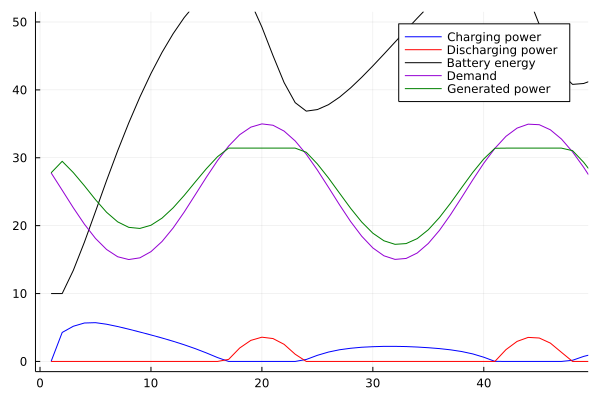

In [19]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(results[!, :E], label="Battery energy", color=:black)
plot!(results[!, :Demand], label="Demand", color=:darkviolet)
plot!(results[!, :P1], label="Generated power", color=:green)
plot!(xlim = [1, 48], ylim = [0, 50])

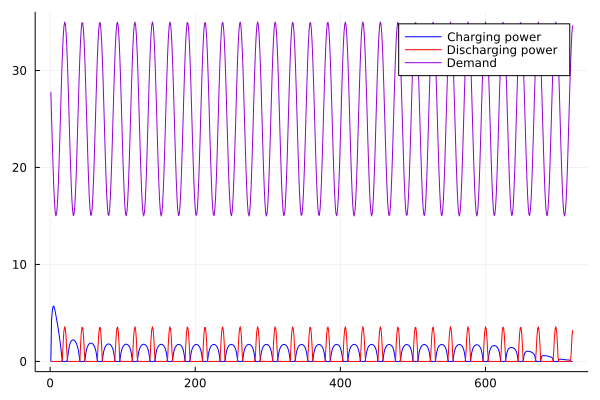

In [20]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(results[!, :Demand], label="Demand", color=:darkviolet)

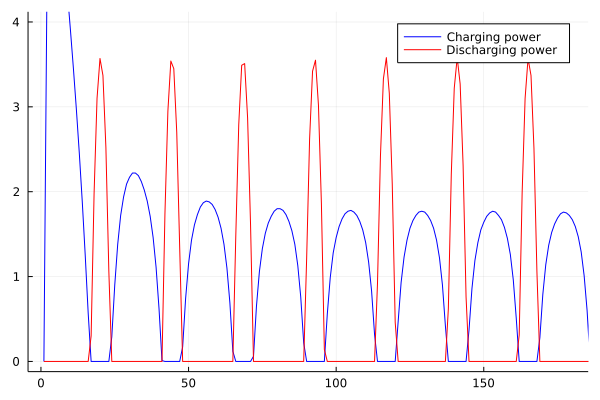

In [21]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(xlim = [1, 180], ylim = [0, 4])